In [21]:
import os
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import time

from keras import models
from keras import layers
from keras.layers import Dropout

import keras
keras.__version__


'2.3.1'

In [22]:
train = pd.read_csv('train.csv')
train.head()

,layer_1,layer_2,layer_3,layer_4,0,1,2,3,4,5,...,216,217,218,219,220,221,222,223,224,225
0,10,10,10,10,0.254551,0.258823,0.254659,0.252085,0.247678,0.253614,...,0.354750,0.369223,0.388184,0.408496,0.414564,0.429403,0.419225,0.443250,0.433414,0.465502
1,10,10,10,20,0.205062,0.225544,0.217758,0.202169,0.199633,0.207380,...,0.557203,0.573656,0.587998,0.612754,0.627825,0.633393,0.637706,0.625981,0.653231,0.637853
2,10,10,10,30,0.189196,0.165869,0.177655,0.156822,0.175094,0.177755,...,0.699864,0.708688,0.721982,0.713464,0.743030,0.741709,0.747743,0.746037,0.737356,0.750391
3,10,10,10,40,0.131003,0.120076,0.138975,0.117931,0.130566,0.131262,...,0.764786,0.763788,0.770017,0.787571,0.778866,0.776969,0.774712,0.801526,0.805305,0.784057
4,10,10,10,50,0.091033,0.086893,0.108125,0.080405,0.105917,0.077083,...,0.786677,0.802271,0.806557,0.799614,0.789333,0.804087,0.787763,0.794948,0.819105,0.801781


In [23]:
X = train.iloc[:,4:] 
X = X.iloc[:,0::2] #짝수번호만

test = pd.read_csv('test.csv')
test = test.iloc[:,1::2]
test.head()

train_data = X
train_targets = train.iloc[:,:4]/10

test_data = test


In [26]:
def build_model():
    # 동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용합니다
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(4))
    model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])
    return model

In [27]:
k = 3
num_val_samples = len(train_data) // k 
num_epochs = 50 
all_mae_histories = []
for i in range(k):
    print('fold #', i) 
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

('fold #', 0)
('fold #', 1)
('fold #', 2)


In [28]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

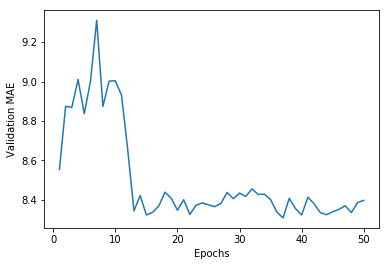

In [29]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [31]:
# 새롭게 컴파인된 모델을 얻습니다
model = build_model()
# 전체 데이터로 훈련시킵니다
model.fit(train_data, train_targets,
          epochs=15, batch_size=16, verbose=0)

In [32]:
pred = model.predict(test_data)
pred

array([[24.289314 , 19.5721   , 15.320464 , 18.761127 ],
       [18.798674 , 12.775526 , 20.844456 ,  9.684746 ],
       [17.537703 , 17.394451 , 24.070625 , 15.878122 ],
       ...,
       [11.831299 , 21.047827 , 18.709225 , 16.558735 ],
       [ 6.875039 ,  7.7663617,  5.95605  ,  8.982084 ],
       [ 6.7472005,  7.583166 ,  6.1208982, 11.430685 ]], dtype=float32)

In [36]:
pred_DL2 = pd.DataFrame(pred*10)

pred_DL2

,0,1,2,3
0,242.893143,195.720993,153.204636,187.611267
1,187.986740,127.755264,208.444550,96.847458
2,175.377029,173.944519,240.706253,158.781219
3,134.956207,158.279831,131.660645,165.311951
4,252.529419,223.590912,226.889191,274.782867
5,200.500488,198.596664,236.840744,209.842224
6,139.908356,162.806427,119.968872,188.036743
7,278.355164,209.000183,218.535843,241.156067
8,114.155388,127.224991,174.482910,120.354248
9,233.379608,206.723495,232.818115,190.264496


In [37]:
pred_DL2.to_csv('pred_DL2.csv')